In [200]:
import warnings
warnings.filterwarnings('ignore')

In [201]:
import numpy as np
import pandas as pd

In [202]:
import math
import re
from collections import Counter

In [203]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 125

### Loading results 

In [204]:
english_incidence_matrix = pd.read_csv('results/english_incidence_matrix.csv', index_col=0)
results_all = pd.read_csv('results/results.csv')
results_single_prob = pd.read_csv('results/results_single_prob.csv')

Adding distances from typical incidence matrix to results dataframes

In [205]:
def get_bigrams(text):
    return re.findall(r'(?=([a-zA-Z]{2}))', text)

def get_bigram_frequencies(text):
    bigrams = get_bigrams(text)
    counts = Counter(bigrams)
    df_counts = pd.DataFrame.from_dict(counts, orient='index').reset_index()
    df_counts = df_counts.rename(columns={'index':'bigram', 0:'frequency'})
    df_counts['first'] = df_counts.bigram.str[0]
    df_counts['second'] = df_counts.bigram.str[1]
    df_counts = df_counts.sort_values('bigram') 
    return df_counts

def create_template_matrix(text):
    index = sorted(list(set(text)))
    columns = index
    num_unique_letters = len(columns)
    data = np.zeros((num_unique_letters, num_unique_letters))
    template_matrix = pd.DataFrame(data, index=index, columns=columns)
    return template_matrix

def get_incidence_matrix(text):
    incidence_matrix = create_template_matrix(text)
    df_bigram_frequencies = get_bigram_frequencies(text)
    for index, row in df_bigram_frequencies.iterrows():
        first, second = row['first'], row['second']
        incidence_matrix.at[first, second] = row['frequency']
    incidence_matrix_probs = incidence_matrix.apply(lambda x: x / incidence_matrix.values.sum())
    incidence_matrix_probs_arr = incidence_matrix_probs.values
    return incidence_matrix_probs_arr

def get_subpart_english_incidence_matrix(text, typical_incidence_matrix): 
    subpart_matrix = create_template_matrix(text)
    for index, row in subpart_matrix.iterrows():
        for col in subpart_matrix.columns:
            subpart_matrix.at[index, col] = typical_incidence_matrix.at[index, col]
    subpart_matrix_probs = subpart_matrix.apply(lambda x: x / subpart_matrix.values.sum())
    subpart_matrix_probs_arr = subpart_matrix_probs.values
    return subpart_matrix_probs
    
def get_dist_from_typical(text, english_bigram_matrix): 
    text_incidence_matrix = get_incidence_matrix(text)
    typical_subpart_incidence_matrix = get_subpart_english_incidence_matrix(text, english_bigram_matrix)
    dist = np.linalg.norm(text_incidence_matrix - typical_subpart_incidence_matrix)
    return dist

In [206]:
results_all['distance'] = results_all['word'].map(lambda text: get_dist_from_typical(text, english_incidence_matrix))
results_single_prob['distance'] = results_single_prob['word'].map(lambda text: get_dist_from_typical(text, english_incidence_matrix))
results_single_prob_small = results_single_prob[results_single_prob.length != 8]
results_all.head()

,order,length,word,prob,exchanges,distance
0,1,2,RM,0.25,0,0.704646
1,1,2,LA,0.25,1,0.900183
2,1,2,RT,0.25,0,0.774815
3,1,2,KD,0.25,0,1.250055
4,1,2,AB,0.25,0,0.721362


### Plots

English incidence matrix visualization

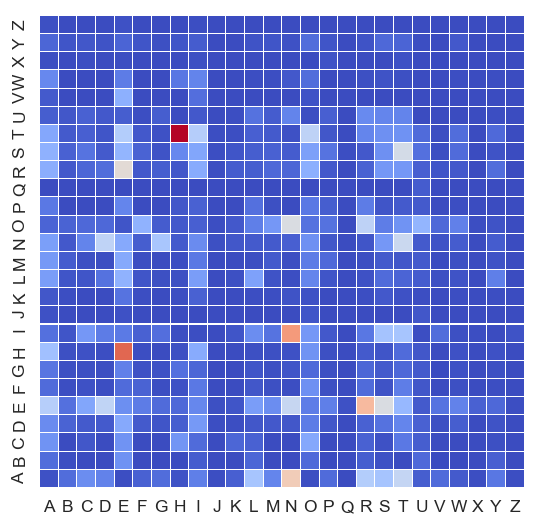

In [207]:
plt.figure(figsize=(5,5))
ax = sns.heatmap(english_incidence_matrix, cmap='coolwarm', cbar=False, linewidth=0.01) 
ax.invert_yaxis()
#ax = sns.clustermap(english_incidence_matrix, cmap='coolwarm', linewidth=0.01)

Number of exchanges as text length changes

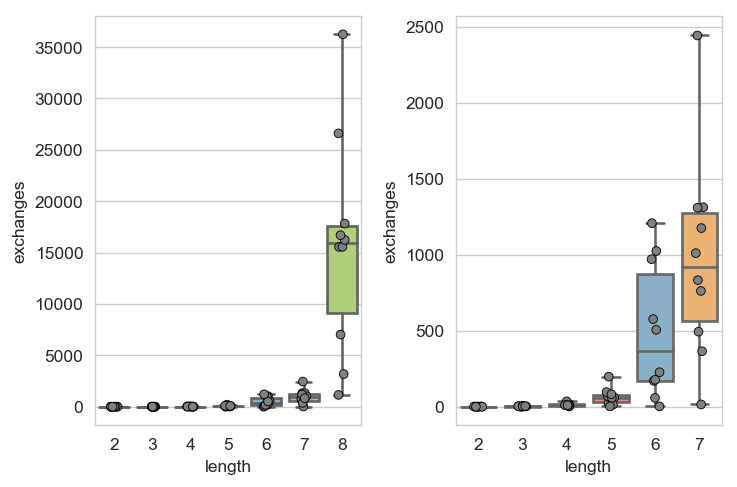

In [208]:
fig, ax = plt.subplots(1,2)
sns.stripplot(x='length', y='exchanges', data=results_single_prob, color='0.5', linewidth=0.5, edgecolor='black', ax=ax[0])
sns.boxplot(x='length', y='exchanges', data=results_single_prob, whis=np.inf, palette='Set3', ax=ax[0])
sns.stripplot(x='length', y='exchanges', data=results_single_prob_small, color='0.5', linewidth=0.5, edgecolor='black', ax=ax[1])
sns.boxplot(x='length', y='exchanges', data=results_single_prob_small, whis=np.inf, palette='Set3', ax=ax[1])
fig.tight_layout()
fig.show()

In [270]:
# mean of number of exchanges
avg_results_single_prob = results_single_prob.groupby(['length', 'exchanges'], as_index=False).mean().groupby('length')['exchanges'].mean()
avg_results_single_prob = avg_results_single_prob.to_frame().reset_index()
avg_results_single_prob.rename(columns = {'exchanges':'mean_exchanges'}, inplace = True) 

# standard deviation of number of exchanges
std_results_single_prob = results_single_prob.groupby(['length', 'exchanges'], as_index=False).mean().groupby('length')['exchanges'].std()
std_results_single_prob = std_results_single_prob.to_frame().reset_index()
std_results_single_prob.rename(columns = {'exchanges':'std_exchanges'}, inplace = True) 

stats_results_single_prob = pd.concat([avg_results_single_prob, std_results_single_prob['std_exchanges']], axis=1)
stats_results_single_prob_small = stats_results_single_prob[stats_results_single_prob.length != 8]
stats_results_single_prob.head(10)


,length,mean_exchanges,std_exchanges
0,2,0.500000,0.707107
1,3,2.666667,2.160247
2,4,12.888889,10.005554
3,5,66.888889,58.353330
4,6,492.100000,439.089576
5,7,972.300000,668.052568
6,8,15602.000000,10489.467225


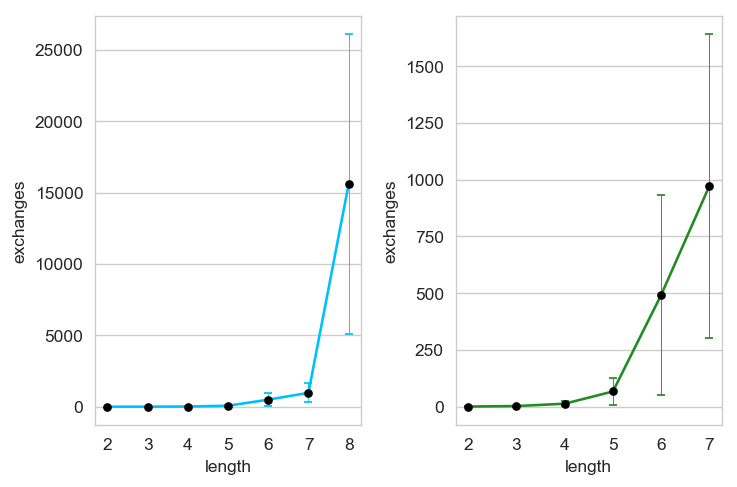

In [433]:
fig, ax_arr = plt.subplots(1,2)

ax_arr[0].errorbar(stats_results_single_prob['length'], stats_results_single_prob['mean_exchanges'], 
             yerr=stats_results_single_prob['std_exchanges'], fmt='o', color='deepskyblue',
             ecolor='deepskyblue', elinewidth=0.5, capsize=2.5, ms=4, 
             markerfacecolor='black', markeredgecolor='black', ls='-')
ax_arr[0].set_xlabel('length')
ax_arr[0].set_ylabel('exchanges')
ax_arr[0].grid(axis='x')
#ax_arr[0].set_xticks(np.arange(stats_results_single_prob['length'].min(), stats_results_single_prob['length'].max()+1, 1))
ax_arr[0].set_xticks(stats_results_single_prob['length'].unique())

ax_arr[1].errorbar(stats_results_single_prob_small['length'], stats_results_single_prob_small['mean_exchanges'], 
             yerr=stats_results_single_prob_small['std_exchanges'], fmt='o', color='forestgreen',
             ecolor='forestgreen', elinewidth=0.5, capsize=2.5, ms=4, 
             markerfacecolor='black', markeredgecolor='black', ls='-')
ax_arr[1].set_xlabel('length')
ax_arr[1].set_ylabel('exchanges')
ax_arr[1].grid(axis='x')
#ax_arr[1].set_xticks(np.arange(stats_results_single_prob_small['length'].min(), stats_results_single_prob_small['length'].max()+1, 1))
ax_arr[1].set_xticks(stats_results_single_prob_small['length'].unique())

fig.tight_layout()
plt.show()

Number of exchanges as distance from typical changes

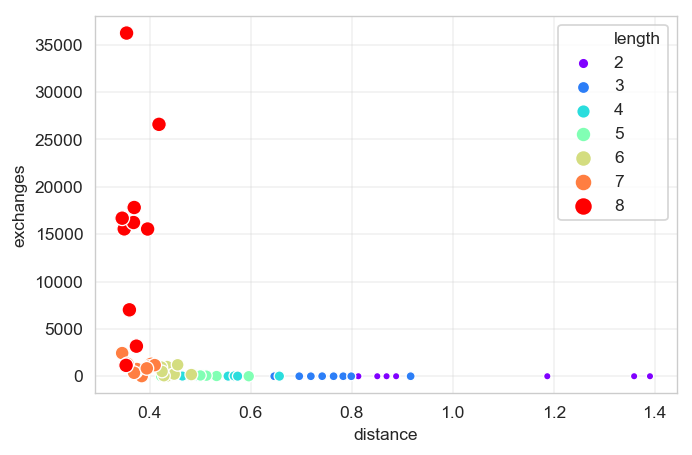

In [434]:
cmap = 'rainbow'
sns.scatterplot(x='distance', y='exchanges', data=results_single_prob, hue='length', size='length', legend='full', palette=cmap)
plt.grid(linestyle='-', linewidth=0.25)
plt.show()

Number of exchanges as exchange probability changes

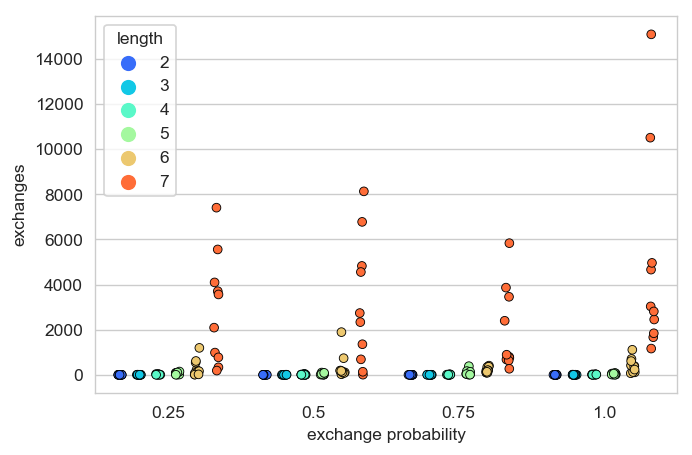

In [343]:
sns.stripplot(x='prob', y='exchanges', data=results_all, hue='length', 
              palette=cmap, linewidth=0.5, edgecolor='black', dodge=True)
plt.xlabel('exchange probability')
plt.show()

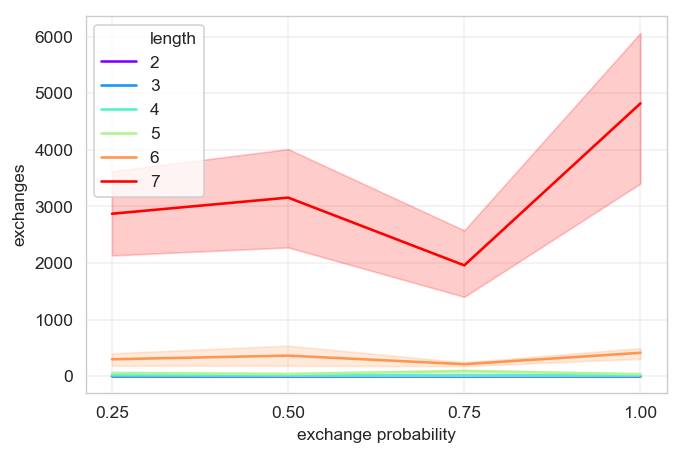

In [430]:
sns.lineplot(x='prob', y='exchanges', hue='length', legend='full', ci=68, palette=cmap, data=results_all)
plt.xticks(results_all_truncated['prob'].unique())
plt.grid(linestyle='-', linewidth=0.25)
plt.xlabel('exchange probability')
plt.show()

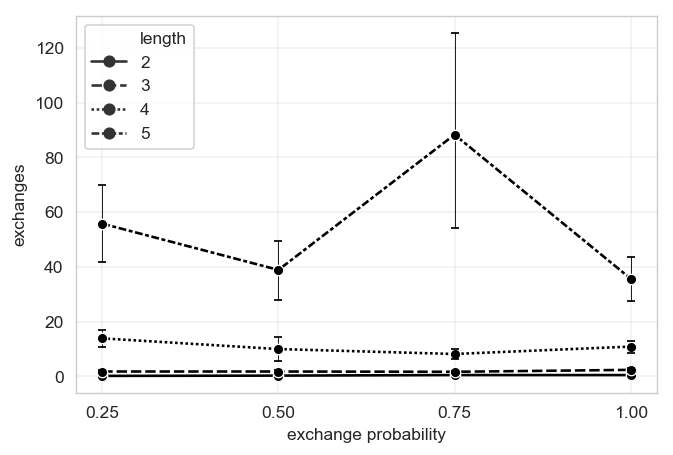

In [455]:
results_all_truncated = results_all[results_all.length <= 5]
num_lengths = results_all_truncated['length'].nunique()
sns.lineplot(x='prob', y='exchanges', style='length', legend='full', markers=['o']*num_lengths, 
             err_style="bars", ci=68, err_kws={'capsize':2.5, 'linewidth':0.5}, color='black', data=results_all_truncated)
             
plt.xticks(results_all_truncated['prob'].unique())
plt.grid(linestyle='-', linewidth=0.25)
plt.xlabel('exchange probability')
plt.show()

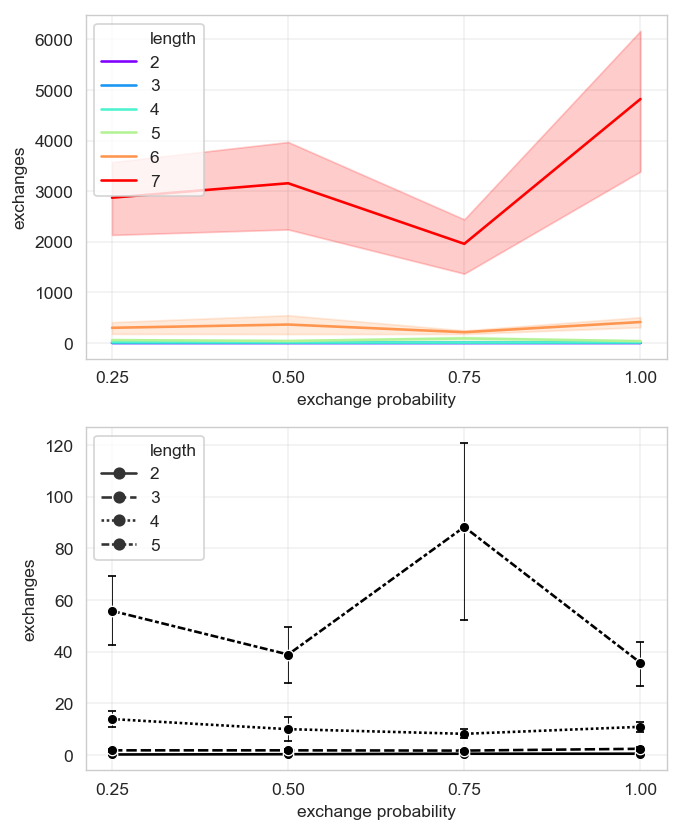

In [456]:
# Combining exchange probability figures into a single one

fig, ax = plt.subplots(2,1, figsize=(6,8))

sns.lineplot(x='prob', y='exchanges', hue='length', legend='full', ci=68, palette=cmap, data=results_all, ax=ax[0])
ax[0].set_xticks(results_all_truncated['prob'].unique())
ax[0].grid(linestyle='-', linewidth=0.25)
ax[0].set_xlabel('exchange probability')

sns.lineplot(x='prob', y='exchanges', style='length', legend='full', markers=['o']*num_lengths, 
             err_style="bars", ci=68, err_kws={'capsize':2.5, 'linewidth':0.5}, color='black', 
             data=results_all_truncated, ax=ax[1])
             
ax[1].set_xticks(results_all_truncated['prob'].unique())
ax[1].grid(linestyle='-', linewidth=0.25)
ax[1].set_xlabel('exchange probability')

#fig.tight_layout()
plt.show()